In [1]:
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn import preprocessing
import urllib
import os
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
P5 = ['ACC','Pac-12','Pac-10','Big East','Big Ten','Big 12','SEC','Notre Dame','Southwest']
G5 = ['Conference USA','Sun Belt','Mid-American','American Athletic','Mountain West','FBS Independents','Western Athletic']

def getTeamInfo(year):
    info_json_url = urllib.request.urlopen('https://api.collegefootballdata.com/teams/fbs?year=%s'%year)
    teamInfo = json.loads(info_json_url.read())
    teamInfo = pd.DataFrame(teamInfo)
    return teamInfo

def seasonProgression(dfR):
    totalGames = len(dfR)
    cWeek = int(dfR['week']) + 1
    return cWeek/(2*totalGames)

def winningTeam(dfR):
    if dfR['home_points'] > dfR['away_points']:
        return dfR['home_team']
    else:
        return dfR['away_team']
    
def teamWin(dfR, team):
    if dfR.winner == team:
        return True
    else:
        return False
    
def findOpp(dfR):
    if dfR.home == True:
        return dfR.away_team
    else:
        return dfR.home_team
def findOppConf(dfR):
    if dfR.home == True:
        return dfR.away_conference
    else:
        return dfR.home_conference
    
def locMult(dfR):
    if dfR['neutral_site'] == True:
        return 1.05
    elif dfR['home'] == True:
        return 1.1
    else:
        return 1.
    
def pointDiff(dfR,team):
    if dfR.home_team == team:
        return dfR.home_points - dfR.away_points
    else:
        return dfR.away_points - dfR.home_points
    
def confMult(dfR):
    if dfR.opp_conference in P5:
        return 1.
    elif dfR.opp_conference in G5:
        return 0.5
    else:
        return 0.15
    
def winQ(dfR,week,FBSdict): 
    if dfR.opp_conference == None:
        oppWinPct = 0.5
    else:
#         print(dfR.opp_conference)
        oppWinPct = FBSdict[dfR.opp].loc[FBSdict[dfR.opp].week <= week, 'winPct'].tail(1).iloc[0]
    
    if dfR.teamWin == True:
        winMult = 1
        oppFactor = oppWinPct
    else:
        winMult = -1
        oppFactor = 1 - oppWinPct
    
    return oppFactor * dfR.seasonProg * dfR.conf_mult * winMult*(dfR.loc_mult + 0.01*dfR.point_diff)

def calcPct(team, week,FBSdict):
    winqweek = 'win_q_'+str(week)
    wins = FBSdict[team].loc[FBSdict[team].week <= week, 'wins'].tail(1).iloc[0]
    losses = FBSdict[team].loc[FBSdict[team].week <= week, 'losses'].tail(1).iloc[0]
    return 0.9 * FBSdict[team].loc[FBSdict[team].week <= week, winqweek].mean() + 0.01*(wins-losses)

In [88]:
def getRanks(year):
    json_url = urllib.request.urlopen('https://api.collegefootballdata.com/games?year=%s&seasonType=regular'%year)
    jsonFile = json.loads(json_url.read())
    curSch = pd.DataFrame(jsonFile)
    
    curWeek = max(curSch['week'])
    
    json_url2 = urllib.request.urlopen('https://api.collegefootballdata.com/games?year=%s&seasonType=postseason'%year)
    jsonFile2 = json.loads(json_url2.read())
    postSch = pd.DataFrame(jsonFile2)
    postSch['week'] = 1 + curWeek
    curSch = curSch.append(postSch)
    curSch = curSch.dropna(subset=['away_points'])
    curSch.loc[curSch.away_team == 'Notre Dame','away_conference'] = 'Notre Dame'
    curSch.loc[curSch.home_team == 'Notre Dame','home_conference'] = 'Notre Dame'
    
    curWeek = max(curSch['week'])
    
    teamInfo = getTeamInfo(year)
    info2019 = teamInfo
    
    for t in teamInfo.index:
        if teamInfo.loc[t].conference == "FBS Independents":
            try:
                conf2019 = info2019.loc[info2019.school == teamInfo.loc[t].school,'conference']
            except ValueError:
                conf2019 = teamInfo.loc[t].conference
            teamInfo.at[t,'conference'] = conf2019

    FBSteams = np.array(teamInfo.school)
    FBSteams.sort()

    FBSdict = {}
    for team in FBSteams:
        FBSdict[team] = curSch[(curSch['away_team'] == team) | 
                               (curSch['home_team'] == team)]
#         FBSdict[team] = FBSdict[team][np.isfinite(FBSdict[team].away_points)]
        FBSdict[team] = FBSdict[team].reset_index()

    FBSbar = tqdm(total=len(FBSteams),desc='Vars:',leave=False)
    for key in FBSdict:
        FBSbar.set_description('Vars: %s'%key)
        FBSdict[key]['seasonProg'] = FBSdict[key].apply(lambda row: seasonProgression(row),axis = 1)
        FBSdict[key]['winner'] = FBSdict[key].apply(lambda row: winningTeam(row),axis = 1)
        FBSdict[key]['teamWin'] = FBSdict[key].apply(lambda row: teamWin(row,key),axis = 1)

        wins = 0
        losses = 0
        winList = []
        lossList = []
        for row in FBSdict[key].itertuples():
        #     print(row.winner)
            if row.teamWin:
                wins += 1
            else:
                losses += 1
            winList.append(wins)
            lossList.append(losses)

        FBSdict[key]['wins'] = winList
        FBSdict[key]['losses'] = lossList

        hometeam = FBSdict[key]['home_team'] == key
        FBSdict[key]['home'] = hometeam

        FBSdict[key]['winPct'] = FBSdict[key]['wins']/(FBSdict[key]['losses'] + FBSdict[key]['wins'])
        FBSdict[key]['opp'] = FBSdict[key].apply(lambda row: findOpp(row), axis = 1)
        FBSdict[key]['opp_conference'] = FBSdict[key].apply(lambda row: findOppConf(row), axis = 1)
        FBSdict[key]['point_diff'] = FBSdict[key].apply(lambda row: pointDiff(row,key), axis = 1)
        FBSdict[key]['loc_mult'] = FBSdict[key].apply(lambda row: locMult(row), axis = 1)
        FBSdict[key]['conf_mult'] = FBSdict[key].apply(lambda row: confMult(row), axis = 1)

        FBSbar.update(1)
    FBSbar.close()
    
    FBSbar2 = tqdm(total=len(FBSteams),desc='WinQ:',leave=False)
    for key in FBSdict:
        FBSbar2.set_description('WinQ: %s'%key)
        for w in range(4,curWeek+1):
            FBSdict[key]['win_q_'+str(w)] = FBSdict[key].apply(lambda row: winQ(row, w, FBSdict),axis=1)
        FBSbar2.update()
    FBSbar2.close()
    
    FBSbar3 = tqdm(total=len(FBSteams),desc='PCT:',leave=False)
    FBSpct = {}
    for key in FBSdict:
        FBSbar3.set_description('PCT: %s'%key)
        pctList = []
        for w in range(4,curWeek+1):
            pctList.append(calcPct(key,w,FBSdict))
        FBSpct[key] = pctList
        FBSbar3.update()
    FBSbar3.close()
    
    if not os.path.exists(str(year)):
            os.mkdir(str(year))

    PCTdf = pd.DataFrame.from_dict(FBSpct,orient='index',columns=range(4,curWeek+1))
    PCTdf.to_csv('%s/PCT.csv'%year)

    PCTnormdf = pd.DataFrame(index = FBSteams,columns=range(4,curWeek+1))

    for w in range(4,curWeek+1):
        x = PCTdf[w].values.reshape(-1,1)
        min_max_scaler = preprocessing.MinMaxScaler()
        xScaled = min_max_scaler.fit_transform(x)
        PCTnormdf[w] = xScaled.reshape(len(FBSteams))

    PCTnormdf.to_csv('%s/PCT_norm.csv'%year)

    Ranks = PCTdf.rank(method='first',ascending=False).astype('int64')
#     print(Ranks)
    Ranks.to_csv('%s/Ranks.csv'%year)

    for w in range(4,curWeek+1):
        Wdf = pd.concat([PCTnormdf[w],Ranks[w]],axis=1)
        Wdf = Wdf.reset_index()
        Wdf.columns = ['Team','PCT','Rank']
        Wdf = Wdf.sort_values('Rank')
        Wdf['PCT'] = Wdf['PCT'].round(3)
        Wdf['Record'] = ['('+str(FBSdict[Wdf['Team'].iloc[i]]['wins'].iloc[-1]) + '-' + str(FBSdict[Wdf['Team'].iloc[i]]['losses'].iloc[-1])+')' for i in range(len(Wdf))]
#         Wdf = Wdf[['Rank','Team','Record','PCT']]
        Wdf = Wdf.set_index('Rank')
        Wdf.to_csv('%s/W%s.csv'%(year,w))
        
        HTMLdf = Wdf.copy()
        HTMLdf['Team'] = ["<img src='%s' width=50px style='float:left; padding: 0px 10px'> "%info2019[info2019['school'] == HTMLdf['Team'].iloc[i]]['logos'].iloc[0][0] + HTMLdf['Team'].iloc[i] for i in range(len(testDF))]
#         HTMLdf['Team'] = [info2019[Wdf['Team']].iloc[i]['']
        HTMLdf.to_csv('%s/W%s_HTML.csv'%(year,w))
    
    return FBSdict, Wdf, info2019, HTMLdf

In [89]:
test, testDF, info, testHTML = getRanks(2019)

In [94]:
testHTML = testHTML.reset_index()
testHTML.to_html('testHTML.html',escape=False,justify='center',index=False)

In [83]:
info[info['school'] == testDF['Team'].iloc[0]]['logos'].iloc[0][0]

'http://a.espncdn.com/i/teamlogos/ncaa/500/99.png'

In [87]:
["<img src='%s' width=50px style='float:left; padding: 0px 10px'> "%info[info['school'] == testDF['Team'].iloc[i]]['logos'].iloc[0][0] + testDF['Team'].iloc[i] for i in range(len(testDF))]

["<img src='http://a.espncdn.com/i/teamlogos/ncaa/500/99.png' width=50px style='float:left; padding: 0px 10px'> LSU",
 "<img src='http://a.espncdn.com/i/teamlogos/ncaa/500/228.png' width=50px style='float:left; padding: 0px 10px'> Clemson",
 "<img src='http://a.espncdn.com/i/teamlogos/ncaa/500/194.png' width=50px style='float:left; padding: 0px 10px'> Ohio State",
 "<img src='http://a.espncdn.com/i/teamlogos/ncaa/500/61.png' width=50px style='float:left; padding: 0px 10px'> Georgia",
 "<img src='http://a.espncdn.com/i/teamlogos/ncaa/500/2483.png' width=50px style='float:left; padding: 0px 10px'> Oregon",
 "<img src='http://a.espncdn.com/i/teamlogos/ncaa/500/201.png' width=50px style='float:left; padding: 0px 10px'> Oklahoma",
 "<img src='http://a.espncdn.com/i/teamlogos/ncaa/500/87.png' width=50px style='float:left; padding: 0px 10px'> Notre Dame",
 "<img src='http://a.espncdn.com/i/teamlogos/ncaa/500/2026.png' width=50px style='float:left; padding: 0px 10px'> Appalachian State",
 "<im

In [42]:
testDF['Record'] = [str(test[testDF['Team'].iloc[i]]['wins'].iloc[-1]) + '-' + str(test[testDF['Team'].iloc[i]]['losses'].iloc[-1]) for i in range(len(testDF))]

In [50]:
testDF

,Team,PCT,Record
Rank,,,
1,LSU,1.000000,(15-0)
2,Clemson,0.868730,(14-1)
3,Ohio State,0.831137,(13-1)
4,Georgia,0.774608,(12-2)
5,Oregon,0.762767,(12-2)
...,...,...,...
126,Arkansas,0.072179,(2-10)
127,UMass,0.046014,(1-11)
128,Old Dominion,0.034714,(1-11)


In [4]:
def plotTeamRank(team,teamInfo,Ranks,year,show=False):
    fig = plt.figure(figsize=(12,5),facecolor='w')
    # plt.subplot(121)
    plt.gca().invert_yaxis()
    plt.title('%s - %s'%(team,year),size=18,fontweight='bold')
#     plt.title('Rankings over the 2019 CFB Season',size=14)
    plt.xlabel('Week',weight='medium')
    plt.ylabel('Rank',weight='medium')
    plt.xticks(fontname = 'NovaMono',weight='medium')
    plt.yticks(fontname = 'NovaMono',weight='medium')
    try:
        teamColor = teamInfo.loc[teamInfo.school == team,'color'].iloc[0]
        teamAltColor = teamInfo.loc[teamInfo.school == team,'alt_color'].iloc[0]
    except ValueError:
        teamColor = 'k'
        teamAltColor = 'w'
    plt.plot(Ranks.loc[team],c=str(teamColor),label=team,lw=5,
             marker = 'o',markersize=10,markerfacecolor=str(teamAltColor),markeredgewidth=2.5,markeredgecolor=str(teamColor))
    plt.tight_layout()
    if not os.path.exists(str(year)+'/Rank Graphs'):
            os.mkdir(str(year)+'/Rank Graphs')
    plt.savefig('%s/Rank Graphs/%s_%s_Ranks.png'%(year,team,year),facecolor=fig.get_facecolor())
    if show:
        plt.show()
    else:
        plt.close()

def graphRanks(year):
    info_json_url = urllib.request.urlopen('https://api.collegefootballdata.com/teams/fbs?year=%s'%year)
    teamInfo = json.loads(info_json_url.read())
    teamInfo = pd.DataFrame(teamInfo)

    Ranks = pd.read_csv('%s/Ranks.csv'%year,index_col=0)
    PCT = pd.read_csv('%s/PCT_norm.csv'%year,index_col=0)

    Ranks = Ranks.sort_values(str(max([int(r) for r in Ranks.columns])))

    TeamList = Ranks.index

    plt.rcParams['font.family'] = 'Roboto Mono'
    plt.rcParams['font.weight'] = 'medium'

    graphBar = tqdm(total=len(TeamList),leave=False)
#     print("Graphing:")
    for team in TeamList:
        graphBar.set_description('Graph: %s'%team)
        plotTeamRank(team,teamInfo,Ranks,year)
        graphBar.update(1)
    graphBar.close() 
    fig = plt.figure(figsize=(12,7),facecolor='w')
    # plt.subplot(121)
    plt.gca().invert_yaxis()
    plt.title('Top Ten Teams, %s'%year,size=18,fontweight='bold')
    # plt.title('Rankings over the 2019 CFB Season',size=14)
    plt.xlabel('Week',weight='medium')
    plt.ylabel('Rank',weight='medium')
    plt.xticks(fontname = 'NovaMono',weight='medium')
    plt.yticks(fontname = 'NovaMono',weight='medium')
#     teamColor = teamInfo[teamInfo.school == team].color.item()
    for team in TeamList[:10]:
        teamColor = teamInfo.loc[teamInfo.school == team,'color'].iloc[0]
        teamAltColor = teamInfo.loc[teamInfo.school == team,'alt_color'].iloc[0]
        plt.plot(Ranks.loc[team],c=str(teamColor),label=team,lw=5,
                 marker = 'o',markersize=10,markerfacecolor=str(teamAltColor),markeredgewidth=2.5,markeredgecolor=str(teamColor))
    plt.legend(bbox_to_anchor=(1, 1.025), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.savefig('%s/topten.png'%year,facecolor=fig.get_facecolor())
    plt.close()
    
    fig = plt.figure(figsize=(12,8),facecolor='w')
    # plt.subplot(121)
    plt.gca().invert_yaxis()
    plt.title('Ranked, %s'%year,size=18,fontweight='bold')
    # plt.title('Rankings over the 2019 CFB Season',size=14)
    plt.xlabel('Week',weight='medium')
    plt.ylabel('Rank',weight='medium')
    plt.xticks(fontname = 'NovaMono',weight='medium')
    plt.yticks(fontname = 'NovaMono',weight='medium')
#     teamColor = teamInfo[teamInfo.school == team].color.item()
    for team in TeamList[:25]:
        teamColor = teamInfo.loc[teamInfo.school == team,'color'].iloc[0]
        teamAltColor = teamInfo.loc[teamInfo.school == team,'alt_color'].iloc[0]
        plt.plot(Ranks.loc[team],c=str(teamColor),label=team,lw=5,
                 marker = 'o',markersize=10,markerfacecolor=str(teamAltColor),markeredgewidth=2.5,markeredgecolor=str(teamColor))
    plt.legend(bbox_to_anchor=(1, 1.025), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.savefig('%s/ranked.png'%year,facecolor=fig.get_facecolor())
    plt.close()

    fig = plt.figure(figsize=(12,7),facecolor='w')
    # plt.subplot(121)
#     plt.gca().invert_yaxis()
    plt.title('Top Ten Teams (PCT), %s'%year,size=18,fontweight='bold')
    # plt.title('Rankings over the 2019 CFB Season',size=14)
    plt.xlabel('Week',weight='medium')
    plt.ylabel('Rank',weight='medium')
    plt.xticks(fontname = 'NovaMono',weight='medium')
    plt.yticks(fontname = 'NovaMono',weight='medium')
#     teamColor = teamInfo[teamInfo.school == team].color.item()
    for team in TeamList[:10]:
        teamColor = teamInfo.loc[teamInfo.school == team,'color'].iloc[0]
        teamAltColor = teamInfo.loc[teamInfo.school == team,'alt_color'].iloc[0]
        plt.plot(PCT.loc[team],c=str(teamColor),label=team,lw=5,
                 marker = 'o',markersize=10,markerfacecolor=str(teamAltColor),markeredgewidth=2.5,markeredgecolor=str(teamColor))
    plt.legend(bbox_to_anchor=(1, 1.025), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.savefig('%s/topten_PCT.png'%year,facecolor=fig.get_facecolor())
    plt.close()
    
    fig = plt.figure(figsize=(12,8),facecolor='w')
    # plt.subplot(121)
#     plt.gca().invert_yaxis()
    plt.title('Ranked (PCT), %s'%year,size=18,fontweight='bold')
    # plt.title('Rankings over the 2019 CFB Season',size=14)
    plt.xlabel('Week',weight='medium')
    plt.ylabel('Rank',weight='medium')
    plt.xticks(fontname = 'NovaMono',weight='medium')
    plt.yticks(fontname = 'NovaMono',weight='medium')
#     teamColor = teamInfo[teamInfo.school == team].color.item()
    for team in TeamList[:25]:
        teamColor = teamInfo.loc[teamInfo.school == team,'color'].iloc[0]
        teamAltColor = teamInfo.loc[teamInfo.school == team,'alt_color'].iloc[0]
        plt.plot(PCT.loc[team],c=teamColor,label=team,lw=5,
                 marker = 'o',markersize=10,markerfacecolor=str(teamAltColor),markeredgewidth=2.5,markeredgecolor=str(teamColor))
    plt.legend(bbox_to_anchor=(1, 1.025), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.savefig('%s/ranked_PCT.png'%year,facecolor=fig.get_facecolor())
    plt.close()
    
    totalRise = Ranks['4'] - Ranks[str(max([int(r) for r in Ranks.columns]))]
    totalRise = totalRise.sort_values()
    biggestRises = totalRise.tail(5)
    biggestFalls = totalRise.head(5)

    fig = plt.figure(figsize=(12,5),facecolor='w')
    # plt.subplot(121)
    plt.gca().invert_yaxis()
    plt.title('Biggest Risers, %s'%year,size=18,fontweight='bold')
    # plt.title('Rankings over the 2019 CFB Season',size=14)
    plt.xlabel('Week',weight='medium')
    plt.ylabel('Rank',weight='medium')
    plt.xticks(fontname = 'NovaMono',weight='medium')
    plt.yticks(fontname = 'NovaMono',weight='medium')
#     teamColor = teamInfo[teamInfo.school == team].color.item()
    for team in biggestRises.index:
        teamColor = teamInfo.loc[teamInfo.school == team,'color'].iloc[0]
        teamAltColor = teamInfo.loc[teamInfo.school == team,'alt_color'].iloc[0]
        plt.plot(Ranks.loc[team],c=str(teamColor),label=team,lw=5,
                 marker = 'o',markersize=10,markerfacecolor=str(teamAltColor),markeredgewidth=2.5,markeredgecolor=str(teamColor))
    plt.legend(bbox_to_anchor=(1, 1.025), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.savefig('%s/risers.png'%year,facecolor=fig.get_facecolor())
    plt.close()
    
    fig = plt.figure(figsize=(12,5),facecolor='w')
    # plt.subplot(121)
    plt.gca().invert_yaxis()
    plt.title('Biggest Falls, %s'%year,size=18,fontweight='bold')
    # plt.title('Rankings over the 2019 CFB Season',size=14)
    plt.xlabel('Week',weight='medium')
    plt.ylabel('Rank',weight='medium')
    plt.xticks(fontname = 'NovaMono',weight='medium')
    plt.yticks(fontname = 'NovaMono',weight='medium')
#     teamColor = teamInfo[teamInfo.school == team].color.item()
    for team in biggestFalls.index:
        teamColor = (teamInfo.loc[teamInfo.school == team,'color'].iloc[0])
        teamAltColor = teamInfo.loc[teamInfo.school == team,'alt_color'].iloc[0]
        plt.plot(Ranks.loc[team],c=teamColor,label=team,lw=5,
                 marker = 'o',markersize=10,markerfacecolor=str(teamAltColor),markeredgewidth=2.5,markeredgecolor=str(teamColor))
    plt.legend(bbox_to_anchor=(1, 1.025), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.savefig('%s/falls.png'%year,facecolor=fig.get_facecolor())
    plt.close()

In [5]:
def histGraph(team,yrange):
    info_json_url = urllib.request.urlopen('https://api.collegefootballdata.com/teams')
    teamInfo = json.loads(info_json_url.read())
    teamInfo = pd.DataFrame(teamInfo)
    
    teamColor = teamInfo.loc[teamInfo.school == team,'color'].iloc[0]

    dfList = []
    weeklenList = [0]
    for y in yrange:
        rank = pd.read_csv('%s/Ranks.csv'%y,index_col=0)
        rank.columns = ["%s W%s"%(str(y)[-2:],w) for w in rank.columns]
        weeklenList.append(len(rank.columns))
        dfList.append(rank)
    for i in range(len(dfList)-1,-1,-1):
    #     print(i)
        try:
            k = dfList[i].loc[team]
        except KeyError:
            startIndex = i+1
            break
        startIndex = 0
    weeklenList = [len(r.columns) for r in dfList[startIndex:]]
#     print(weeklenList)
    rank = dfList[startIndex]
    rank = rank.join(dfList[startIndex+1:])
    fillList = [w + sum(weeklenList[:i]) for i,w in enumerate(weeklenList)]

    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(35,5))
    plt.gca().invert_yaxis()
    plt.margins(x=0)
    plt.plot(rank.loc[team],color=teamColor)
    plt.xticks([])
    plt.title(team,size=18,weight='bold')
    for i in range(0,len(fillList)-1):
        if i%2 == 0:
            plt.fill_between(fillList[i:i+2],max(rank.loc[team])*1.1,alpha=0.05,color=teamColor)
        if i == 0:
            plt.text(fillList[i]+weeklenList[1]/3,max(rank.loc[team]*1.08),yrange[i])
        else:
            plt.text(fillList[i]+weeklenList[i]/3,max(rank.loc[team]*1.08),yrange[i])
    plt.tight_layout()
    plt.savefig('HistGraphs/Ranks/%s_%s-%s.png'%(team,yrange[0],yrange[-1]),facecolor=fig.get_facecolor())
    plt.close()

In [6]:
def histGraphPCT(team,yrange,show=False):
    info_json_url = urllib.request.urlopen('https://api.collegefootballdata.com/teams')
    teamInfo = json.loads(info_json_url.read())
    teamInfo = pd.DataFrame(teamInfo)
    
    teamColor = teamInfo.loc[teamInfo.school == team,'color'].iloc[0]
    teamAltColor = teamInfo.loc[teamInfo.school == team,'alt_color']

    dfList = []
    weeklenList = [0]
    for y in yrange:
        ranks = pd.read_csv('%s/PCT_norm.csv'%y,index_col=0)
        ranks.columns = ["%s W%s"%(str(y)[-2:],w) for w in ranks.columns]
#         weeklenList.append(len(ranks.columns))
        dfList.append(ranks)
    
    for i in range(len(dfList)-1,-1,-1):
    #     print(i)
        try:
            k = dfList[i].loc[team]
        except KeyError:
            startIndex = i+1
            break
        startIndex = 0
    weeklenList = [len(r.columns) for r in dfList[startIndex:]]
#     print(weeklenList)
    rank = dfList[startIndex]
    rank = rank.join(dfList[startIndex+1:])
    fillList = [w + sum(weeklenList[:i]) for i,w in enumerate(weeklenList)]
#     print(fillList)
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(35,5))
#     plt.gca().invert_yaxis()
    plt.margins(x=0)
    plt.xticks([])
    plt.title(team,size=24,weight='bold')
    plt.ylabel('Normalized Rating')
    plt.ylim(-0.1,1.1)
    plt.plot(rank.loc[team],color=teamColor)
    for i in range(0,len(fillList)):
        if i%2 == 0:
            plt.fill_between(fillList[i:i+2],1,alpha=0.05,color=teamColor)
        if i == 0:
            plt.text(weeklenList[0]/3,-0.1,yrange[startIndex])
        else:
            plt.text(fillList[i-1]+weeklenList[1]/3,-0.1,yrange[startIndex+i])
    plt.tight_layout()
    plt.savefig('HistGraphs/%s_%s-%s_PCT.png'%(team,yrange[0],yrange[-1]),facecolor=fig.get_facecolor())
    if show:
        plt.show()
    else:
        plt.close()

In [11]:
getRanks(2019)
graphRanks(2019)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [18]:
final2019 = pd.read_csv('2019/W16.csv')
final2019.columns = ['Team','PCT','Rank']
final2019[['Rank','Team','PCT']].head(25).set_index('Rank')
# print(final2019[['Rank','Team','PCT']].head(25).set_index('Rank'))

,Team,PCT
Rank,,
1,LSU,1.000000
2,Clemson,0.868730
3,Ohio State,0.831137
4,Georgia,0.774608
5,Oregon,0.762767
6,Oklahoma,0.743346
7,Notre Dame,0.722580
8,Appalachian State,0.704809
9,Florida,0.691093


In [9]:
# yrange = range(1990,2020)
yrange=range(1991,2001)

In [10]:
yBar = tqdm(total=len(yrange))
for y in yrange:
    yBar.set_description(str(y))
    getRanks(y)
    graphRanks(y)
    yBar.update(1)

In [11]:
teamInfo = getTeamInfo(2019)
exceptList = []
for t in teamInfo.school:
    try:
        histGraph(t,range(1990,2020))
        histGraphPCT(t,range(1990,2020),show=False)
    except KeyError:
        exceptList.append(t)
        plt.close()
        continue

***

In [12]:
def getRankInfo(year):
    info_json_url = urllib.request.urlopen('https://api.collegefootballdata.com/rankings?year=%s&seasontype=regular'%year)
    teamInfo = json.loads(info_json_url.read())
    teamInfo = pd.DataFrame(teamInfo)
    return teamInfo

In [13]:
ranks2019 = getRankInfo(2019)

In [14]:
for i in range(len(ranks2019.loc[15].polls)):
    pollName = ranks2019.loc[15].polls[i]['poll'].replace(' ', '_')
    pollWeek = ranks2019.loc[15].week - 1
    pollData = pd.DataFrame(ranks2019.loc[15].polls[i]['ranks']).sort_values('rank')
    pollData = pollData[['school','points','rank']]
    pollData.to_csv('2019/W%s_%s.csv'%(pollWeek,pollName),index=False)

In [15]:
mPoll = pd.read_csv('2019/W15.csv',names=['school','PCT','Mrank'],header=0)
# mPoll.columns = [['school','PCT','Rank']]
coachPoll = pd.read_csv('2019/W15_Coaches_Poll.csv')
APPoll = pd.read_csv('2019/W15_AP_Top_25.csv')
CFPPoll = pd.read_csv('2019/W15_Playoff_Committee_Rankings.csv')

In [16]:
coachList = []
APList = []
CFPList = []
for t in mPoll.school:
    try:
#         print(t)
        coachList.append(int(coachPoll.loc[coachPoll.school == t,'rank'].iloc[0]))
    except IndexError:
        coachList.append(None)
    try:
#         print(t)
        APList.append(int(APPoll.loc[APPoll.school == t,'rank'].iloc[0]))
    except IndexError:
        APList.append(None)
    try:
#         print(t)
        CFPList.append(int(CFPPoll.loc[CFPPoll.school == t,'rank'].iloc[0]))
    except IndexError:
        CFPList.append(None)

In [17]:
mPoll['coachRanks'] = coachList
mPoll['APRanks'] = APList
mPoll['CFPRanks'] = CFPList

In [18]:
compDF = pd.concat([mPoll.head(25),mPoll[25:].dropna(subset=['coachRanks','APRanks','CFPRanks'],thresh=1)])

In [19]:
compDF['delCoach'] = compDF.Mrank - compDF.coachRanks
compDF['delAP'] = compDF.Mrank - compDF.APRanks
compDF['delCFP'] = compDF.Mrank - compDF.CFPRanks
compDF = compDF[['school','PCT','Mrank','coachRanks','delCoach','APRanks','delAP','CFPRanks','delCFP']]
compDF.columns = ['school','PCT','M','coach','delCoach','AP','delAP','CFP','delCFP']

In [20]:
compDF.to_csv('2019/W%s_comparison.csv'%pollWeek,index=False)

***

In [20]:
from sklearn.cluster import KMeans

In [21]:
def KM(data,n_clusters,n_init=10):
    
    clf = KMeans(n_clusters = n_clusters, n_init = n_init)
    clf.fit(data)
    
    centers = clf.cluster_centers_
    
    labels = clf.predict(data)
    
    KMArr = np.hstack((data,labels.reshape(len(data),1)))

    
    return KMArr, centers

In [21]:
mPoll = pd.read_csv('2019/W16.csv',names=['school','PCT','Mrank'],header=0)

In [22]:
mPoll

,school,PCT,Mrank
0,LSU,1.000000,1
1,Clemson,0.963738,2
2,Ohio State,0.885761,3
3,Georgia,0.821263,4
4,Oregon,0.808691,5
...,...,...,...
125,Arkansas,0.075456,126
126,UMass,0.047675,127
127,Old Dominion,0.035678,128
128,UTEP,0.020586,129


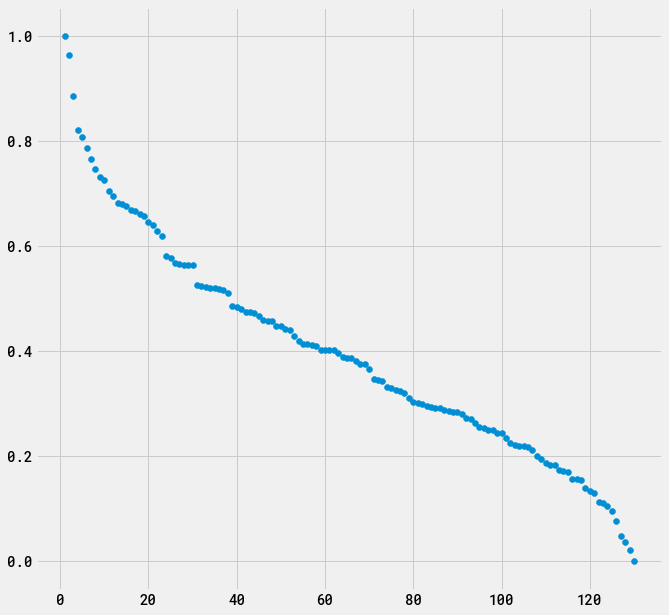

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(mPoll.Mrank,mPoll.PCT)